In [18]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

"""Script: make fxw plot of distribution from FW summaries.

Created on Sun May 23 2021

@author: yoav
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import concurrent.futures as cf
from itertools import product
import glob as glob
import xml.etree.ElementTree as ET
import re as re
from matplotlib import cm

In [19]:
def data_from_files(metadata):
    """Get data from files.
    
    Extract data from the files in the fw subfolder of metadata["folder"]
    """

    datas = [[{} for w in metadata["file_ws"]] for f in metadata["file_fs"]]
    metas = [[{**metadata} for w in metadata["file_ws"]] for f in metadata["file_fs"]]
    for i,f in enumerate(metadata["file_fs"]):
        for j,w in enumerate(metadata["file_ws"]):
            meta = metas[i][j]
            meta["file_fs"] = f
            meta["file_ws"] = w
            meta["folder"] = metadata["folder"] + f"/f{f}w{w}"

    arg_generator = (
                     (datas[i[0]][i[1]], metas[i[0]][i[1]])
                     for i in 
                     product( range(len(metadata["file_fs"])), range(len(metadata["file_ws"])) )
                    )

    with cf.ThreadPoolExecutor() as ex:
        ex.map(tuple_args_ij_files, arg_generator)
    #for args in arg_generator:
    #    tuple_args_ij_files(args)


    return datas #and update metadata


def tuple_args_ij_files(arg_tuple):
    """Wrap single file function for map."""
    dist_from_ij(*arg_tuple)


def dist_from_ij(data, meta):
    """Get cluster distribution of a single folder."""
    #  start
    pystat_names = ("No", "Volume", "Area", "lambda1",
                    "lambda2", "lambda3", "Nbw/Nb", "hbar",
                    "mean_cluster_size", "std_cluster_size",
                    "line_length", "asphericity", "gyration_radius",
                    "acylindricity",
                   )
    stat_names = ("Epoch","OuterLoop", "VertexMoveSucessRate",
                  "BondFlipSuccessRate"
                 )
    

    if meta["data_type"] in pystat_names:
        # get a main_statistics or pystatisics 
        # (regular statistics: output of trisurf)
        stat_csv = glob.glob(meta["folder"]+'/[mp]*.csv')[0]
        df = pd.read_csv(stat_csv)
        data["x"] = df["No"][meta["slice"]]
        
    elif meta["data_type"] in stat_names:
        # get stuff that only exists in statistics.csv
        df = pd.read_csv(meta["folder"]+'/statistics.csv')
        data["x"] = df["OuterLoop"][meta["slice"]]

    # use options
    if meta["data_type"]=='asphericity':
        data["y"] = (df['lambda3'][meta["slice"]]
                        - 0.5*df['lambda2'][meta["slice"]]
                        - 0.5*df['lambda1'][meta["slice"]])
    elif meta["data_type"]=='gyration_radius':

        data["y"] = (df['lambda1'][meta["slice"]]
                        + df['lambda2'][meta["slice"]]
                        + df['lambda3'][meta["slice"]])
    elif meta["data_type"]=='acylindricity':

        data["y"] = (df['lambda2'][meta["slice"]]
                        - df['lambda1'][meta["slice"]])
    else:

        data["y"] = df[meta["data_type"]][meta["slice"]]
        
    if meta["do_mean"]:
        data["mean"] = data["y"].mean()
    if meta["do_std"]:
        data["std"] = data["y"].std()

    timestep_vtu = glob.glob(meta["folder"] + "/timestep*.vtu")
    # parse vtu as xml file
    tree = ET.parse(timestep_vtu[-1])
    root = tree.getroot()
    
    # directly extract the one tape
    tape = root.findall('tape')[0].text
    f_regex = re.compile(r"\n(F=[\d.]+)")
    w_regex = re.compile(r"\n(w=[\d.]+)")
    true_f = re.findall(f_regex, tape)[0]
    true_w = re.findall(w_regex, tape)[0]
    data["f"] = float(true_f[2:])
    data["w"] = float(true_w[2:])

In [62]:
def plot_fxw(datas, metadata):
    """Plot fxw graphs.

    plot fxw graphs in a square, in a matrixlike form
    from a fxw list of datas
    """
    def dist_label_mean(x):
        return fr'$\mu = {x:.2f}$'

    def dist_label_std(x):
        return fr'$\sigma = {x:.2f}$'
    
    #def axis_range(min_val,max_val):
    #    mid = (max_val + min_val) /2
    #    dif = (max_val - min_val) /2
    #    return mid-1.05*dif, mid+1.05*dif

    i_range, j_range = list(range(len(datas))), list((range(len(datas[0]))))
    if metadata["order"] == "matrix":
        x_range, y_range = i_range, j_range
        xy_of_ij = [ [ (x,y) for y,j in zip(j_range[::-1],j_range)] for x,i in zip(i_range,i_range)] # for i: for j: x=xy_of-ij[i,j,0]
        ij_of_xy = [ [ (i,j) for j,y in zip(y_range[::-1],y_range)] for i,x in zip(x_range,x_range)] # for x: for y: i=ij_of_xy[x,y,0]
    else:
        x_range, y_range = j_range, i_range
        xy_of_ij = [ [ (x,y) for x,j in zip(j_range,j_range)] for y,i in zip(i_range,i_range)] # for i: for j: x=xy_of-ij[i,j,0]
        ij_of_xy = [ [ (i,j) for i,y in zip(y_range,y_range)] for x,j in zip(x_range,x_range)] # for x: for y: i=ij_of_xy[x,y,0]

    xy_datas = [ [datas[ij_of_xy[x][y][0]][ij_of_xy[x][y][1]] for y in y_range] for x in x_range ]
    
    if metadata["plot_type"] == "pcolor":
        #pcolor is a single mesh
        if "axe_scale" in metadata:
            plt.xscale(metadata["axe_scale"][0])
            plt.yscale(metadata["axe_scale"][1])
        # data key:
        if metadata["do_mean"]:
            key="mean"
        elif metadat["do_std"]:
            key="std"
        else:
            key="y"
        
        # order of pcolor is inherently matrix, so we need to flip the Y
        if metadata[örder] == "matrix":
            mesh = [[data[key] for data in datastrip ] for datastrip in datas]
            X = [[data["f"] for data in datastrip ] for datastrip in datas]
            Y = [[data["w"] for data in datastrip ] for datastrip in datas]
        else:
            mesh = [[data[key] for data in datastrip ] for datastrip in xy_datas]
            X = [[data["f"] for data in datastrip ] for datastrip in xy_datas]
            Y = [[data["w"] for data in datastrip ] for datastrip in xy_datas]
        if metadata["order"] == "w(F)":
            X, Y = Y, X
        plt.pcolormesh( X, Y, mesh,
                    shading="auto",
                    **{key: value for key,value in metadata["plot_kwargs"].items()
                            if key not in {"color","bottom"}}
                    )
        if metadata["order"] == "matrix":
            plt.xlabel("f")
            plt.ylabel("w")
        else:
            plt.xlabel("w")
            plt.ylabel("f")
        if metadata["do_title"]:
            plt.title(f' FW plot:: {metadata["data_type"]}')
            
        plt.xticks([a[0] for a in X])
        plt.yticks(Y[0])
        plt.yaxis()
        return True
        


    # make big figure
    plt.rcParams['figure.figsize'] = [20, 18] # [10,6.8] # [20,18]
    if "axe_share" in metadata:
        fig, axes = plt.subplots(nrows=len(y_range), ncols=len(x_range), sharex=metadata["axe_share"][0], sharey=metadata["axe_share"][1], num=metadata["data_type"])
    else:
        fig, axes = plt.subplots(nrows=len(y_range), ncols=len(x_range), num=metadata["data_type"])


    for x in x_range:
        for y in reversed(y_range):
            axe = axes[y, x]
            data = xy_datas[x][y]
            
            if "axe_scale" in metadata:
                axe.set_xscale(metadata["axe_scale"][0])
                axe.set_yscale(metadata["axe_scale"][1])

            if metadata["plot_type"] == "plot":
                axe.plot(data["x"], data["y"],
                         **{key: value for key,value in metadata["plot_kwargs"].items()
                            if key not in {"bottom", "cmap"}}
                        )
            elif metadata["plot_type"] == "bar":
                axe.bar(data["x"], data["y"],
                         **{key: value for key,value in metadata["plot_kwargs"].items()
                            if key not in {"cmap"}}
                       )
            elif metadata["plot_type"] == "stem":
                axe.stem(data["x"], data["y"],
                         **{key: value for key,value in metadata["plot_kwargs"].items()
                            if key not in {"color","cmap"}}
                        )
            elif metadata["plot_type"] == "hist":
                axe.hist(data["y"],
                         **{key: value for key,value in metadata["plot_kwargs"].items() 
                            if key not in {"cmap"}}
                        )
            

            
            if metadata["do_legend"]:
                # custom legend
                axe.plot([], [], marker='.', color='red',
                         label=dist_label_mean(data["mean"]))
                axe.plot([], [], marker='.', color='red',
                         label=dist_label_std(data["std"]))
            # plot parameters

            #if metadata["plot_range"] == "equal" or metadata["plot_range"]=="x_along_columns":
            #    if y==max(y_range) :
            #        axe.set_xlim(*axis_range(min_data_x[x][y], max_data_x[x][y]))
            #    else:
            #        axe.sharex(axes[0, x])
            #        axe.tick_params(labelbottom=False)
            #else:
            #    axe.set_xlim(*axis_range(min_data_x[x][y], max_data_x[x][y]))

            #if metadata["plot_range"] == "equal" or metadata["plot_range"]=="y_along_rows":
            #    if x == min(x_range) :
            #        axe.set_ylim(*axis_range(min_data_y[x][y], max_data_y[x][y]))
            #    else:
            #        axe.sharey(axes[y, min(x_range)])
            #        axe.tick_params(labelleft=False)
            #else:
            #    axe.set_ylim(*axis_range(min_data_y[x][y], max_data_y[x][y]))


            if metadata["do_title"]:
                axe.set_title(f' f={data["f"]}, w={data["w"]}: {metadata["data_type"]}')
            # axe.set_aspect('equal', 'box')

            if metadata["do_legend"]:
                axe.legend(numpoints=1, handlelength=0,
                           markerscale=0, handletextpad=0)

    plt.tight_layout()
    plt.show()
    return True

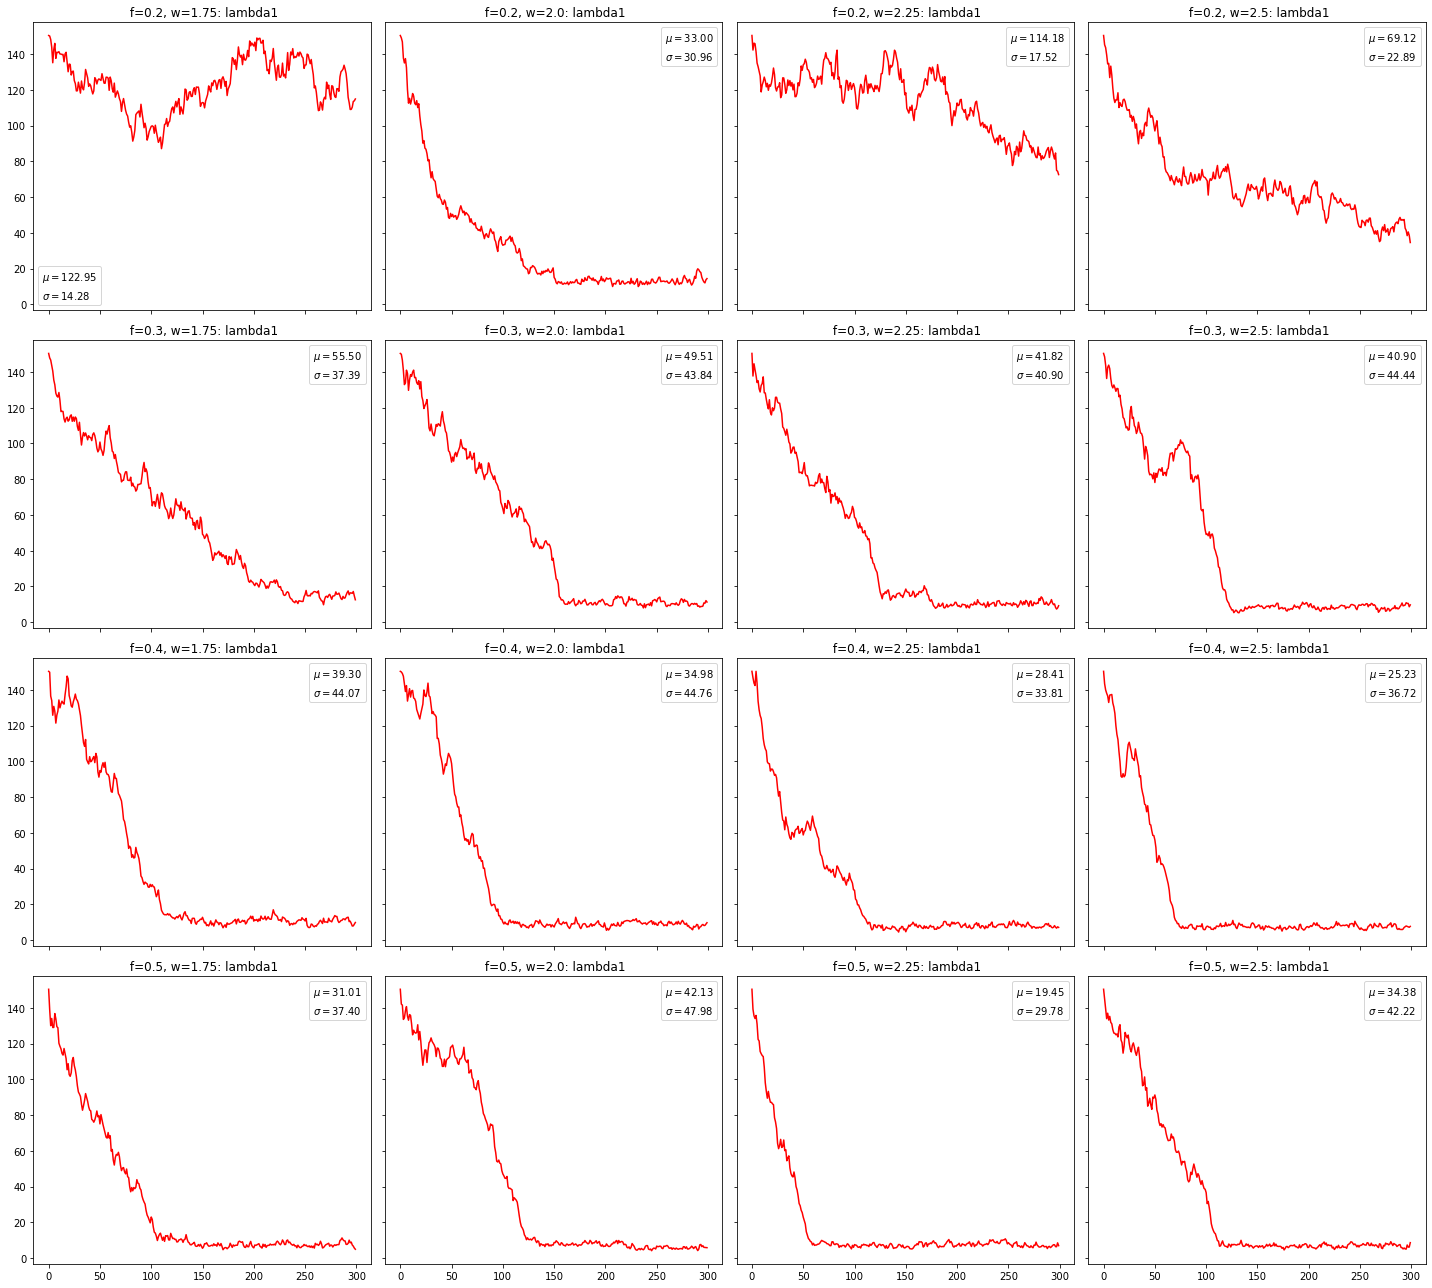

True

In [63]:

%matplotlib inline
"""Do main function.

does the thing
"""
main_loc = (r'/mnt/c/Users/yoavr/Desktop'
            r'/paraview_pipeline/hello_chemfarm'
            #r'/FW_block_aggregated/timesteps'
            #r'/HIV_gag/1_attempt_1'
            r'/13_from_various_stability/2_from_buds' # goes to 300, 4x4
            #r'/HIV_gag/2_attempt_2'
            #r'/HIV_gag/4_lines' # goes to 150
            #r'/HIV_gag/3_fixed' # 5x5
            )
metadata={}
metadata["data_type"]= "lambda1" # lamdba1,lambda2,lamdba3, Area, Volume, mean_cluster_size, asphericity, gyration_radius, acylindricity
metadata["slice"]=slice(0,-1)
metadata["folder"]=main_loc
metadata["do_mean"]=True
metadata["do_std"]=True
metadata["file_fs"] = [0,1,2,3]  # range f [2,6|5,9]
metadata["file_ws"] = [0,1,2,3]
metadata["axe_share"] = (True, True) # sharex, sharey
metadata["order"] = "ij=wf" # ij=fw ij=wf xy=fw xy=wf
metadata["do_legend"] = True
metadata["do_title"] = True
metadata["plot_type"] = "plot" # pcolor*, plot, bar, hist, stem
metadata["axe_scale"] = "linear", "linear" # "linear", "log", "symlog", "logit"
metadata["plot_kwargs"] = {"bottom": 1, "color": 'red', "cmap":cm.coolwarm}



datas = data_from_files(metadata)


plot_fxw(datas, metadata)




In [ ]:
main_loc = (r'/mnt/c/Users/yoavr/Desktop'
            r'/paraview_pipeline/hello_chemfarm'
            #r'/FW_block_aggregated/timesteps'
            #r'/HIV_gag/1_attempt_1'
            r'/13_from_various_stability/2_from_buds' # goes to 300, 4x4
            #r'/HIV_gag/2_attempt_2'
            #r'/HIV_gag/4_lines' # goes to 150
            #r'/HIV_gag/3_fixed' # 5x5
            )
with open(main_loc+"/simulations_parameters") as f:
    tapedata=f.read()
[x.split() for x in tapedata.splitlines()]

In [112]:
datalist=[{} for i in range(4)]
datalist[0]["a"]=[1,2,3]
datalist

[{'a': [1, 2, 3]}, {}, {}, {}]

In [113]:
g = {**datalist[0]}

In [114]:
g['a']=2
g

{'a': 2}

In [117]:
"a" in datalist[0]

True

In [168]:
a=-1
b=-4
g=[1,2,3,4,5,6,7,8,9]
g[b:a]
list(product([1,2,3],['a','b','c']))
a=[[1,2,3],[4,5,6],[7,8,9]]
transpose(a)

NameError: name 'transpose' is not defined

In [101]:
tree = ET.parse(r"/mnt/c/Users/yoavr/Desktop/paraview_pipeline/hello_chemfarm/FW_block_aggregated/timesteps/f0w10/timestep_000000.vtu")
root = tree.getroot()

# directly extract the one tape
tape = root.findall('tape')[0].text
f_regex = re.compile(r"\n(F=[\d.]+)")
w_regex = re.compile(r"\n(w=[\d.]+)")
tape, re.findall(f_regex, tape) ,re.findall(w_regex, tape)

('####### Vesicle definitions ###########\n# nshell is a number of divisions of dipyramid\nnshell=30\n# dmax is the max. bond length (in units l_min)\ndmax=1.7\n# dmin_interspecies in the min. dist. between different vertex species (in units l_min)\ndmin_interspecies=1.2\n# bending rigidity of the membrane (in units kT)\nxk0=28.5\n# max step size (in units l_min)\nstepsize=0.15\n\n# Pressure calculations\n# (pswitch=1: calc. p*dV energy contribution)\npswitch = 0\n# pressure difference: p_inside - p_outside (in units kT/l_min^3):\npressure=0.1\n\n#Constant volume constraint (0 disable constant volume, 1 enable wiht additional vertex move, 2 enable with epsvol)\nconstvolswitch=0\nconstvolprecision=1e-14\n\n#Constant area constraint (0 disable constant area, 2 enable constant area with epsarea)\nconstareaswitch=0\n\n\n#Stretching\nstretchswitch=0\nxkA0=1.0\n\n####### Polymer (brush) definitions ###########\n# npoly is a number of polymers attached to npoly distinct vertices on vesicle\nn

In [106]:
wc = re.compile(r"\n(w=[\d.]+)")
a = re.findall(wc,"F=20\nw=2.5")
float(a[0][2:])

2.5

In [162]:
df= pd.read_csv(r"/mnt/c/Users/yoavr/Desktop/paraview_pipeline/hello_chemfarm/FW_block_aggregated/timesteps/f0w10/main_statistics.csv")
df?

Type:        DataFrame
String form:
No        Volume         Area     lambda1     lambda2     lambda3  \
           0      0  43969.258491 <...>   0.083630  0.066961          26.470588         30.726856   317.734004
           
           [200 rows x 11 columns]
Length:      200
File:        ~/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py
Docstring:  
Two-dimensional, size-mutable, potentially heterogeneous tabular data.

Data structure also contains labeled axes (rows and columns).
Arithmetic operations align on both row and column labels. Can be
thought of as a dict-like container for Series objects. The primary
pandas data structure.

Parameters
----------
data : ndarray (structured or homogeneous), Iterable, dict, or DataFrame
    Dict can contain Series, arrays, constants, dataclass or list-like objects. If
    data is a dict, column order follows insertion-order.

    .. versionchanged:: 0.25.0
       If data is a list of dicts, column order follows insertion-order.


In [31]:
X = [[1,2,3],[1,2,3],[1,2,3]]

In [33]:
Y= [[1,1,1],[2,2,2],[3,3,3]]

In [36]:
[a[0] for a in Y]

[1, 2, 3]